
Membangun model Word2Vec dari kumpulan dataset

In [ ]:
!pip install --upgrade gensim

import gensim
import pandas as pd
import tensorflow as tf
import numpy as np
import nltk
from nltk.corpus import stopwords
import os
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, GlobalAveragePooling1D, Conv1D, Flatten, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from sklearn.metrics import roc_curve, auc, classification_report 
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('punkt')
print(gensim.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


4.2.0


## Preprocess

In [ ]:
train = pd.read_csv("data_worthcheck/train.csv")
test = pd.read_csv("data_worthcheck/test.csv")
development = pd.read_csv("data_worthcheck/dev.csv")

In [ ]:
train.head()

,Unnamed: 0,text_a,label
0,0,betewe buka twitter cuman ngetweet liat home b...,no
1,1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,2,e100ss gini buka informasi sejelas nya identit...,yes
3,3,neng solo wes ono terduga corona cobo neng ati...,no
4,4,midiahn nii akun gak takut takut nya isu coron...,no


Drop column

In [ ]:
train = train.drop('Unnamed: 0', axis=1) 
train = train.drop_duplicates()
train.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no


Drop duplicate

In [ ]:
test = test.drop_duplicates()
test.head()

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes


In [ ]:
development = development.drop_duplicates()
development.head()

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes


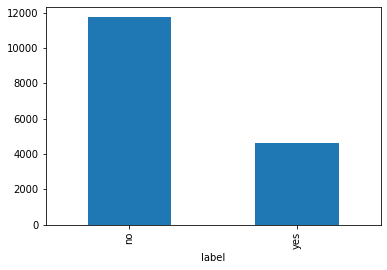

In [ ]:
train.groupby(['label']).size().plot.bar()

Remove stopwords

In [ ]:
## Remove stopwords
stop = stopwords.words('indonesian')

train['text_a'] = train['text_a'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
development['text_a'] = development['text_a'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['text_a'] = test['text_a'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Encode label

In [ ]:
## Ubah label ke numerik

train['label'] = train['label'].map( {'yes': 1, 'no': 0} ).astype(int)
development['label'] = development['label'].map( {'yes': 1, 'no': 0} ).astype(int)
test['label'] = test['label'].map( {'yes': 1, 'no': 0} ).astype(int)

Tokenization

In [ ]:
data = pd.concat([train, test, development], ignore_index=True)
data.head()

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,0
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,0
2,e100ss gini buka informasi sejelas nya identit...,1
3,neng solo wes ono terduga corona cobo neng ati...,0
4,midiahn nii akun gak takut takut nya isu coron...,0


In [ ]:
texts = data["text_a"]

texts

0        betewe buka twitter cuman ngetweet liat home b...
1        mas piyuuu mugo2 corona tuh mulut tersumpal ma...
2        e100ss gini buka informasi sejelas nya identit...
3        neng solo wes ono terduga corona cobo neng ati...
4        midiahn nii akun gak takut takut nya isu coron...
                               ...                        
21938    ku tenang2 bae ku sih ya corona nya ga depok k...
21939    guru hati hati ya virus corona uda indonesia t...
21940    4 terawan menyebut virus corona indonesia terd...
21941          realffk buhari can t pronounce corona virus
21942    hadapi wabah corona pemuda muhammadiyah pemeri...
Name: text_a, Length: 21943, dtype: object

In [ ]:
texts = texts.apply(nltk.word_tokenize)
texts

0        [betewe, buka, twitter, cuman, ngetweet, liat,...
1        [mas, piyuuu, mugo2, corona, tuh, mulut, tersu...
2        [e100ss, gini, buka, informasi, sejelas, nya, ...
3        [neng, solo, wes, ono, terduga, corona, cobo, ...
4        [midiahn, nii, akun, gak, takut, takut, nya, i...
                               ...                        
21938    [ku, tenang2, bae, ku, sih, ya, corona, nya, g...
21939    [guru, hati, hati, ya, virus, corona, uda, ind...
21940    [4, terawan, menyebut, virus, corona, indonesi...
21941    [realffk, buhari, can, t, pronounce, corona, v...
21942    [hadapi, wabah, corona, pemuda, muhammadiyah, ...
Name: text_a, Length: 21943, dtype: object

New Word2Vec model from dataset

In [ ]:
model_10 = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4,
)

model_5 = gensim.models.Word2Vec(
    window=5,
    min_count=2,
    workers=4,
)

In [ ]:
model_10.build_vocab(texts, progress_per=1000)
model_5.build_vocab(texts, progress_per=1000)

In [ ]:
model_10.train(texts, total_examples=model_10.corpus_count, epochs=model_10.epochs)
model_5.train(texts, total_examples=model_5.corpus_count, epochs=model_5.epochs)

(1400283, 1721840)

In [ ]:
model_10.wv.most_similar("mahasiswa")

[('gereja', 0.9967455863952637),
 ('keberadaan', 0.9952825307846069),
 ('palsu', 0.9945448637008667),
 ('rahasiakan', 0.9943862557411194),
 ('biaya', 0.994238555431366),
 ('dibalik', 0.9936500787734985),
 ('cak', 0.9935745596885681),
 ('dngn', 0.9934371113777161),
 ('dugaan', 0.992937445640564),
 ('hukuman', 0.9928697347640991)]

In [ ]:
model_5.wv.most_similar("mahasiswa")

[('omg', 0.9968777298927307),
 ('gmna', 0.9968095421791077),
 ('dagang', 0.9966608285903931),
 ('ajah', 0.9963656067848206),
 ('diajak', 0.9962037205696106),
 ('sd', 0.9960975050926208),
 ('twit', 0.9958769679069519),
 ('ramai', 0.9957376718521118),
 ('cinta', 0.9957149028778076),
 ('buru', 0.99550861120224)]

In [ ]:
filename_10 = "data_worthcheck_10.txt"
filename_5 = "data_worthcheck_5.txt"
model_10.wv.save_word2vec_format(filename_10, binary=False)

In [ ]:
embedding_index = {}
f = open(os.path.join('', filename_10), encoding="utf-8")

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:])
  embedding_index[word] = coefs

f.close

<function TextIOWrapper.close()>

Buat model deep learning dan gunakan model Word2Vec ke dalam Embedding layer

In [ ]:
X_train, X_dev, X_test, y_train, y_dev, y_test = train["text_a"], development["text_a"], test["text_a"], train["label"], development["label"], test["label"]

In [ ]:
train["text_a"]

0        betewe buka twitter cuman ngetweet liat home b...
1        mas piyuuu mugo2 corona tuh mulut tersumpal ma...
2        e100ss gini buka informasi sejelas nya identit...
3        neng solo wes ono terduga corona cobo neng ati...
4        midiahn nii akun gak takut takut nya isu coron...
                               ...                        
17420    mengejutkan 2 cases covid 19 indonesia tenaga ...
17422    null komentar iwan fals virus corona indonesia...
17424    null komentar iwan fals virus corona indonesia...
17426    giapratamamd kalo ga berinteraksi orang positi...
17427    a a a a girls jujur ya sayang banget stay safe...
Name: text_a, Length: 16349, dtype: object

In [ ]:
tokenizer_obj = Tokenizer(oov_token="<OOV>", num_words=1000)
tokenizer_obj.fit_on_texts(X_train)
tokenizer_obj.fit_on_texts(X_test)
tokenizer_obj.fit_on_texts(X_dev)

sequences_train = tokenizer_obj.texts_to_sequences(X_train)
sequences_test = tokenizer_obj.texts_to_sequences(X_test)
sequences_dev = tokenizer_obj.texts_to_sequences(X_dev)

In [ ]:
texts.head()

0    [betewe, buka, twitter, cuman, ngetweet, liat,...
1    [mas, piyuuu, mugo2, corona, tuh, mulut, tersu...
2    [e100ss, gini, buka, informasi, sejelas, nya, ...
3    [neng, solo, wes, ono, terduga, corona, cobo, ...
4    [midiahn, nii, akun, gak, takut, takut, nya, i...
Name: text_a, dtype: object

In [ ]:
word_index = tokenizer_obj.word_index
max_length = 100
vocab_size = len(word_index) + 1

In [ ]:
print(vocab_size)

50100


In [ ]:
print(max_length)

100


In [ ]:
train_padded = pad_sequences(sequences_train, maxlen=max_length)
dev_padded = pad_sequences(sequences_dev, maxlen=max_length)
test_padded = pad_sequences(sequences_test, maxlen=max_length)

train_padded.shape

(16349, 100)

In [ ]:
num_words = len(word_index) + 1
print(num_words)
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
  if i > num_words:
    continue

  embedding_vector = embedding_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

50100


Inisiasi model deep learning

Menggunakan embedding layer tanpa model Word2Vec

In [ ]:
tf.config.run_functions_eagerly(False)

model = Sequential()
model.add(Embedding(vocab_size, 16, input_length=max_length))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_padded, y_train, epochs=20, validation_data=(dev_padded, y_dev), verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           801600    
                                                                 
 conv1d_3 (Conv1D)           (None, 98, 32)            1568      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 49, 32)           0         
 1D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1568)              0         
                                                                 
 dense_8 (Dense)             (None, 10)                15690     
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                      

In [ ]:
y_pred = (model.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names= {'no': 0, 'yes': 1} )) 


              precision    recall  f1-score   support

          no       0.88      0.87      0.87      2092
         yes       0.62      0.63      0.63       705

    accuracy                           0.81      2797
   macro avg       0.75      0.75      0.75      2797
weighted avg       0.81      0.81      0.81      2797



Susunan layer sama namun menggunakan word2vec embedding sebagai initializer

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=100))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_padded, y_train, epochs=20, validation_data=(dev_padded, y_dev), verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          5010000   
                                                                 
 conv1d_5 (Conv1D)           (None, 98, 32)            9632      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 49, 32)           0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 1568)              0         
                                                                 
 dense_12 (Dense)            (None, 10)                15690     
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                      

In [ ]:
tf.config.run_functions_eagerly(False)

y_pred = (model.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names= {'no': 0, 'yes': 1} )) 

              precision    recall  f1-score   support

          no       0.90      0.85      0.87      2092
         yes       0.62      0.72      0.67       705

    accuracy                           0.82      2797
   macro avg       0.76      0.79      0.77      2797
weighted avg       0.83      0.82      0.82      2797



Menggunakan Word2Vec dan GRU layer

In [ ]:
tf.config.run_functions_eagerly(True)

model = Sequential()
embedding_layer = Embedding(vocab_size, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix), input_length=100)
model.add(embedding_layer)
model.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation="sigmoid"))

print(model.summary())

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          5010000   
                                                                 
 gru_1 (GRU)                 (None, 32)                12864     
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,022,897
Trainable params: 5,022,897
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
tf.config.run_functions_eagerly(True)

model.fit(train_padded, y_train, batch_size=128, epochs=20, validation_data=(dev_padded, y_dev), verbose=1)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


128/128 [==============================] - 175s 1s/step - loss: 0.4923 - accuracy: 0.7587 - val_loss: 0.4060 - val_accuracy: 0.8216
Epoch 2/20
128/128 [==============================] - 184s 1s/step - loss: 0.4037 - accuracy: 0.8227 - val_loss: 0.3787 - val_accuracy: 0.8363
Epoch 3/20
128/128 [==============================] - 173s 1s/step - loss: 0.3792 - accuracy: 0.8337 - val_loss: 0.3643 - val_accuracy: 0.8391
Epoch 4/20
128/128 [==============================] - 183s 1s/step - loss: 0.3594 - accuracy: 0.8453 - val_loss: 0.3554 - val_accuracy: 0.8455
Epoch 5/20
128/128 [==============================] - 173s 1s/step - loss: 0.3435 - accuracy: 0.8524 - val_loss: 0.3531 - val_accuracy: 0.8427
Epoch 6/20
128/128 [==============================] - 174s 1s/step - loss: 0.3328 - accuracy: 0.8580 - val_loss: 0.3447 - val_accuracy: 0.8534
Epoch 7/20
128/128 [==============================] - 175s 1s/step - loss: 0.3238 - accuracy: 0.8655 - val_loss: 0.3442 - val_accuracy: 0.8513
Epoch 8/20

In [ ]:
tf.config.run_functions_eagerly(False)

y_pred = (model.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names= {'no': 0, 'yes': 1} )) 

              precision    recall  f1-score   support

          no       0.89      0.92      0.90      2092
         yes       0.73      0.66      0.69       705

    accuracy                           0.85      2797
   macro avg       0.81      0.79      0.80      2797
weighted avg       0.85      0.85      0.85      2797



Saving model

In [ ]:
model.save("models/non_contextual_word2vec.h5")

Load model

In [ ]:
loaded_model = tf.keras.models.load_model('models/non_contextual_word2vec.h5')

In [ ]:
y_pred = (loaded_model.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names= {'no': 0, 'yes': 1} )) 

              precision    recall  f1-score   support

          no       0.89      0.90      0.90      2092
         yes       0.70      0.68      0.69       705

    accuracy                           0.85      2797
   macro avg       0.80      0.79      0.79      2797
weighted avg       0.84      0.85      0.85      2797



Menggunakan trained W2V bahasa indonesia

Source:

https://medium.com/@diekanugraha/membuat-model-word2vec-bahasa-indonesia-dari-wikipedia-menggunakan-gensim-e5745b98714d

In [51]:
filename = 'idwiki_word2vec_100_new_lower.model'
path = os.path.join('', filename)
id_w2v = gensim.models.word2vec.Word2Vec.load(path)

In [59]:
id_w2v.build_vocab(texts, progress_per=1000, update=True)
id_w2v.train(texts, total_examples=id_w2v.corpus_count, epochs=id_w2v.epochs)

(1215012, 1721840)

In [53]:
def gensim_to_keras_embedding(model, train_embeddings=False):
    """Get a Keras 'Embedding' layer with weights set from Word2Vec model's learned word embeddings.

    Parameters
    ----------
    train_embeddings : bool
        If False, the returned weights are frozen and stopped from being updated.
        If True, the weights can / will be further updated in Keras.

    Returns
    -------
    `keras.layers.Embedding`
        Embedding layer, to be used as input to deeper network layers.

    """
    keyed_vectors = model.wv  # structure holding the result of training
    weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array    
    index_to_key = keyed_vectors.index_to_key  # which row in `weights` corresponds to which word?

    layer = Embedding(
        input_dim=weights.shape[0],
        output_dim=weights.shape[1],
        weights=[weights],
        trainable=train_embeddings,
    )
    return layer

In [60]:
loaded_embed_layer = gensim_to_keras_embedding(id_w2v, True)

In [61]:
model_pre = Sequential()
model_pre.add(loaded_embed_layer)
model_pre.add(GRU(units=32, dropout=0.2, recurrent_dropout=0.2))
model_pre.add(Dense(1, activation="sigmoid"))

print(model_pre.summary())

model_pre.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_pre.fit(train_padded, y_train, epochs=20, validation_data=(dev_padded, y_dev), verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 100)         34316800  
                                                                 
 gru_3 (GRU)                 (None, 32)                12864     
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 34,329,697
Trainable params: 34,329,697
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
511/511 [==============================] - 131s 252ms/step - loss: 0.5030 - accuracy: 0.7591 - val_loss: 0.4643 - val_accuracy: 0.7826
Epoch 2/20
511/511 [==============================] - 128s 250ms/step - loss: 0.4286 - accuracy: 0.8056 - val_loss: 0.4195 - val_accuracy: 0.8098
Epoch 3/2

In [62]:
y_pred = (model_pre.predict(test_padded) > 0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names= {'no': 0, 'yes': 1} )) 

              precision    recall  f1-score   support

          no       0.88      0.92      0.90      2092
         yes       0.73      0.63      0.68       705

    accuracy                           0.85      2797
   macro avg       0.80      0.78      0.79      2797
weighted avg       0.84      0.85      0.84      2797

